In [7]:
import os
import copy
import salem
from oggm import cfg, utils, workflow, graphics, tasks
from oggm.core.flowline import equilibrium_stop_criterion, FileModel
import oggm
import plot_gcm
from functools import partial
import random
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import plot_gcm
import importlib
import dask
from dask.diagnostics import ProgressBar

from cycler import cycler
import matplotlib as mpl
from matplotlib import colors
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

mpl.rcParams['axes.linewidth'] = 3
mpl.rcParams['xtick.major.width'] = 3
mpl.rcParams['ytick.major.width'] = 3
mpl.rcParams['font.size'] =30
mpl.rcParams['font.weight'] = 'medium'
mpl.rcParams['axes.labelweight'] = 'medium'
mpl.rcParams['legend.fontsize'] = 20 #30
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['xtick.major.pad']='8'
mpl.rcParams['ytick.major.pad']='8'
mpl.rcParams["figure.figsize"] = (15,10)

dask.config.set({"array.slicing.split_large_chunks": False})

# create cmap
color_list=[colors.to_rgb('#'+c) for c in ["001219","003946","005f73","0a9396","4fb3aa","94d2bd","e9d8a6","ecba53","ee9b00","dc8101","bb3e03","8d210c","5e0314"]]
gcm_cmap = cmap = mpl.colors.ListedColormap(color_list)
custom_cycler = cycler(color=gcm_cmap.colors)

In [309]:
READING_DIR='out/run_CMIP6_geod'

# read geodetic output
with ProgressBar():
    p = os.path.join(READING_DIR,'*_equilibrium.nc')
    all_ds = xr.open_mfdataset(p, parallel=True)
    
all_ds = all_ds.assign_coords({"region": all_ds.rgi_id.str[6:8]})
#all_ds = all_ds.sel(rgi_id=all_ds.region=='03').equilibrium

#i_ds = xr.open_dataset('interpolated_ds.nc')
#i_ds = i_ds.assign_coords({"region": i_ds.rgi_id.str[6:8]}).sel(rgi_id=i_ds.region=='03').equilibrium

merge_ds = xr.open_dataset('merge_ds.nc')
merge_ds = merge_ds.sel(rgi_id=merge_ds.region=='03')

ex_2_hot=['FGOALS-f3-L', 'BCC-CSM2-MR', 'MRI-ESM2-0', 'MPI-ESM1-2-HR', 'ACCESS-CM2', 'MIROC6', 'CESM2', 'GISS-E2-2-H','CRU']
all_ds = all_ds.sel(gcm=ex_2_hot)
merge_ds = merge_ds.sel(gcm=ex_2_hot)

[########################################] | 100% Completed |  0.3s


NameError: name 'i_ds' is not defined

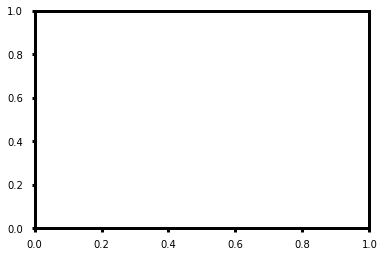

In [3]:
ax=plt.gca()
ids = i_ds.sel(rgi_id=i_ds.region=='03').sel(gcm='CanESM5').dropna(dim='rgi_id', how='any').rgi_id.values
df = all_ds.sel(rgi_id=ids, gcm='CanESM5').to_pandas()
# subset of glaciers with incomplete time series
sub_df = df[df.isna().sum(axis=1)!=0]
# filter outliers from these glaciers
sub_df = sub_df[sub_df.sub(df.mean(axis=1), axis=0).le(3*sub_df.std(axis=1), axis=0)]

df.T.plot(legend=False, ax=ax, alpha=0.3, color='grey');
sub_df.T.plot(legend=False, ax=ax, marker='o', markersize=4, color='grey');

ax.set_title('incomplete glaciers (region 03, CanESM5)')
ax.set_xlabel('Time (years)')
ax.set_ylabel(r'Volume (km$^3$)');

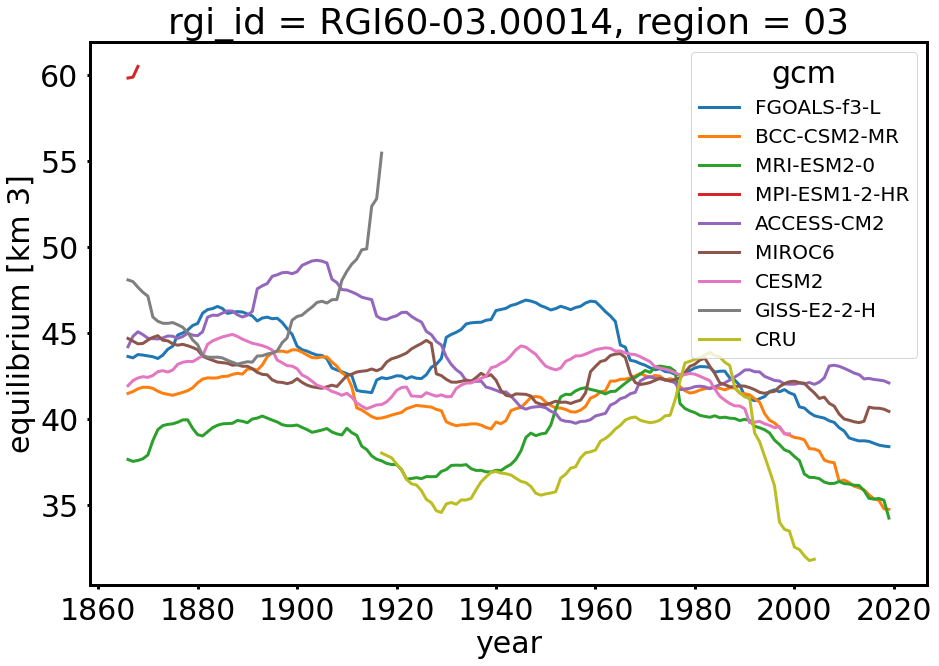

In [232]:
all_ds.sel(rgi_id='RGI60-03.00014').plot(hue='gcm');

### Find out which gcm failed for which glaciers:

In [319]:
failed=pd.DataFrame(index=all_ds.rgi_id)
for gcm in all_ds.gcm:
    failed.loc[:,str(gcm.values)]=np.array(all_ds.sel(gcm=gcm).equilibrium.dropna(dim='year', how='all').isnull().to_pandas().sum(axis=1).clip(0,1).values)

In [351]:
failed[failed.sum(axis=1)!=0].to_csv('run_reverse.txt')

In [286]:
failed = pd.read_csv('run_reverse.txt',index_col=0)
failed = failed[failed.index.str.startswith('RGI60-'+'03')]
rgi_id = failed.iloc[[0]].index
to_run = failed[failed>0].iloc[[0]].dropna(axis=1).columns.to_numpy()

In [350]:
df = failed[failed.sum(axis=1)!=0]
df.loc[:,'region']=df.index.str[6:8]
df.region.value_counts().sort_index().sub(1)

01     497
02     386
03     570
04    1350
05    2969
06      45
07     751
08     280
09     340
10     601
11      11
12      18
13    2039
14     814
15      45
16      66
17     435
18      11
Name: region, dtype: int64

In [346]:
df[df.region=='01']

,FGOALS-f3-L,BCC-CSM2-MR,MRI-ESM2-0,MPI-ESM1-2-HR,ACCESS-CM2,MIROC6,CESM2,GISS-E2-2-H,CRU,region
RGI60-01.00060,1,0,1,1,1,1,0,1,1,01
RGI60-01.00198,1,1,1,1,1,1,1,1,1,01
RGI60-01.00268,1,1,1,1,1,1,0,1,1,01
RGI60-01.00294,1,1,1,1,1,1,1,1,1,01
RGI60-01.00327,1,0,0,1,1,1,0,0,1,01
...,...,...,...,...,...,...,...,...,...,...
RGI60-01.26696,1,1,1,1,1,1,1,1,1,01
RGI60-01.26750,1,0,0,1,0,1,0,0,1,01
RGI60-01.26963,0,0,0,0,1,1,0,0,1,01
RGI60-01.27049,1,1,1,1,1,1,1,1,1,01


## check geometry of some failed glaciers

In [16]:
df = all_ds.sel(rgi_id=i_ds.sel(gcm='CanESM5').dropna(dim='rgi_id', how='all').rgi_id.values,gcm='CanESM5').dropna(dim='rgi_id', how='all')
failed_id = df.rgi_id.values

KeyError: "not all values found in index 'rgi_id'"

Initialize OGGM


In [3]:
# Initialize OGGM and set up the default run parameters
cfg.initialize()
cfg.set_logging_config(logging_level='WARNING')
cfg.PATHS['working_dir'] = os.path.join('out','run_CMIP6_geod')

# Use multiprocessing?
cfg.PARAMS['use_multiprocessing'] = True

# store model geometry
cfg.PARAMS['store_model_geometry'] = True

 # climate settings
cfg.PARAMS['hydro_month_nh']=1
cfg.PARAMS['hydro_month_sh']=1
cfg.PARAMS['climate_qc_months']=0

# How many grid points around the glacier?
# Make it large if you expect your glaciers to grow large
cfg.PARAMS['border'] = 160

path = utils.get_rgi_region_file('03', version='61')
rgidf = gpd.read_file(path).set_index('RGIId')


2022-11-22 10:36:31: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2022-11-22 10:36:31: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2022-11-22 10:36:31: oggm.cfg: Multiprocessing: using all available processors (N=32)
2022-11-22 10:36:31: oggm.utils: Checking the download verification file checksum...
2022-11-22 10:36:31: oggm.cfg: Multiprocessing switched ON after user settings.
2022-11-22 10:36:31: oggm.cfg: PARAMS['store_model_geometry'] changed from `False` to `True`.
2022-11-22 10:36:31: oggm.cfg: PARAMS['hydro_month_nh'] changed from `10` to `1`.
2022-11-22 10:36:31: oggm.cfg: PARAMS['hydro_month_sh'] changed from `4` to `1`.
2022-11-22 10:36:31: oggm.cfg: PARAMS['climate_qc_months'] changed from `3` to `0`.
2022-11-22 10:36:31: oggm.cfg: PARAMS['border'] changed from `40` to `160`.


In [ ]:
# Go - initialize glacier directories
#gdirs = workflow.init_glacier_regions(['RGI60-11.00897','RGI60-11.00779'], from_prepro_level=3, reset=False)
gdirs = workflow.init_glacier_directories(rgidf.loc[failed_id].reset_index(), reset=False)

In [65]:
oggm.__version__

'1.5.3.dev14+g25c4675'

In [ ]:
from matplotlib.collections import LineCollection
from matplotlib.legend_handler import HandlerLineCollection
importlib.reload(plot_gcm)
viridis=mpl.cm.get_cmap('viridis', 154)
gcm='CanESM5'
for gdir in gdirs:
    
    fls = gdir.read_pickle('model_flowlines')
    fig = plt.figure(figsize=(15,12))
    #ax1=plt.gca()
    grid = plt.GridSpec(4, 4, hspace=1, wspace=0.5)
    ax1 = fig.add_subplot(grid[2:, :])
    ax2 = fig.add_subplot(grid[1, :])
    x = (fls[-1].to_diagnostics_dataset().dis_along_flowline.values)/1000
    ax1.plot(x,fls[-1].surface_h, color='k', linestyle=':',label='RGI state')

    vol = pd.DataFrame()
    for p in [os.path.join(gdir.dir,file) for file in os.listdir(gdir.dir) if file.startswith('model_geometry'+gcm)]:

        try:
            t = p.split('_')[-1].split('.nc')[0]
            #print(t)
            fmod = FileModel(p)
            fmod.run_until(fmod.volume_km3_ts().dropna().index[-1])
            if len(x)==len(fmod.fls[-1].surface_h):
                ax1.plot(x,fmod.fls[-1].surface_h, label=t)
                vol.loc[t,'volume']=fmod.volume_km3

        except:
            pass
    ax1.plot(x,fls[-1].bed_h, color='k')
    #ax1.set_xlim((0,65))
    ax1.set_xlabel('Distance along the flowline (km)')
    ax1.set_ylabel('Altitude (m)')
    ax1.legend()
    
    all_ds.sel(rgi_id=gdir.rgi_id,gcm='CanESM5').plot(ax=ax2)
    ax2.set_title(gdir.rgi_id)
    ax2.set_ylabel(r'equilibrium ($km^3$)')
    ax2.set_xlim(1866,2019);
    '''
    vol.index = vol.index.astype('int')
    vol = vol.sort_index()
    y = vol.volume.values
    x = vol.volume.index

    dydx = x  


    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Create a continuous norm to map from data points to colors
    norm = plt.Normalize(dydx.min(), dydx.max())
    lc = LineCollection(segments, cmap='viridis_r', norm=norm)
    # Set the values used for colormapping
    lc.set_array(dydx)
    lc.set_linewidth(2)
    line = ax2.add_collection(lc)
    fig.colorbar(line, ax=[ax1,ax2], label='Time (years)')
    ax2.set_xlim((1866,2020))
    ax2.set_ylim((y.min()-2,y.max()+2))
    ax2.set_xlabel('Time (years)')
    ax2.set_ylabel(r'Volume (km$^3$)', labelpad=20)
    ax2.set_title(gdir.rgi_id, pad=20)

    lc = LineCollection(segments, cmap='viridis_r',
                        norm=plt.Normalize(0, 10), linewidth=3)
    lc2 = LineCollection(segments, color='k', linestyle=':',
                         norm=plt.Normalize(0, 10), linewidth=3)

    l1 = ax1.legend(handles=[lc, lc2], handler_map={
        lc: plot_gcm.HandlerColorLineCollection(numpoints=100)},
                    labels=['equilibrium state', 'RGI state'], loc=1)
    '''
    plt.savefig(os.path.join('out','run_CMIP6_geod','plots','glacier','RGI03',gdir.rgi_id+'.png'),dpi=300);

## Example 1 
(Exploding equilibrium volume, error disappeared when running it again)

In [9]:
gdirs1 = [gdir for gdir in gdirs if gdir.rgi_id=='RGI60-03.02881']
ela=oggm.utils.compile_ela(gdirs1, filesuffix='CanESM5',ys=1850, ye=2034, climate_filename='gcm_data', climate_input_filesuffix='CanESM5') 

2022-11-09 08:19:25: oggm.utils: Applying global task compile_ela on 1 glaciers
2022-11-09 08:19:25: oggm.workflow: Execute entity tasks [compute_ela] on 1 glaciers


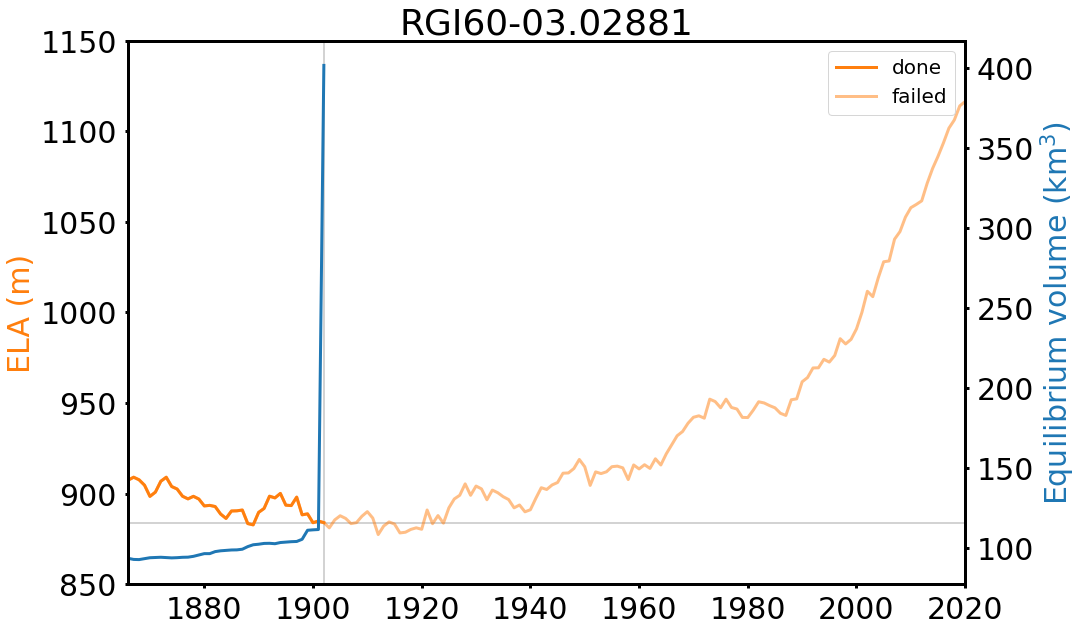

In [91]:
ax=plt.gca()
ela.rolling(30, center=True).mean().loc[:1902].plot(ax=ax, label='done', color='C1')
ela.rolling(30, center=True).mean().plot(ax=ax, legend='failed', color='C1',alpha=0.5)
ax.hlines(y=ela.rolling(30, center=True).mean().loc[1902].values[0], xmin=1860, xmax=2020, lw=2,color='lightgrey')
ax.vlines(x=1902, ymin=850, ymax=1150, lw=2,color='lightgrey')

ax2=ax.twinx()
all_ds.sel(rgi_id=gdirs1[0].rgi_id, gcm='CanESM5').plot(ax=ax2)

plt.xlabel('Time (years)')
ax.set_ylabel('ELA (m)', color='C1')
ax2.set_ylabel(r'Equilibrium volume (km$^3$)', color='C0')
plt.title(gdirs1[0].rgi_id)
ax.legend(['done', 'failed'])
plt.xlim((1866,2020))
ax.set_ylim((850,1150));
plt.savefig(os.path.join('out','run_CMIP6_geod','plots','error_ice_cap.png'),dpi=300);

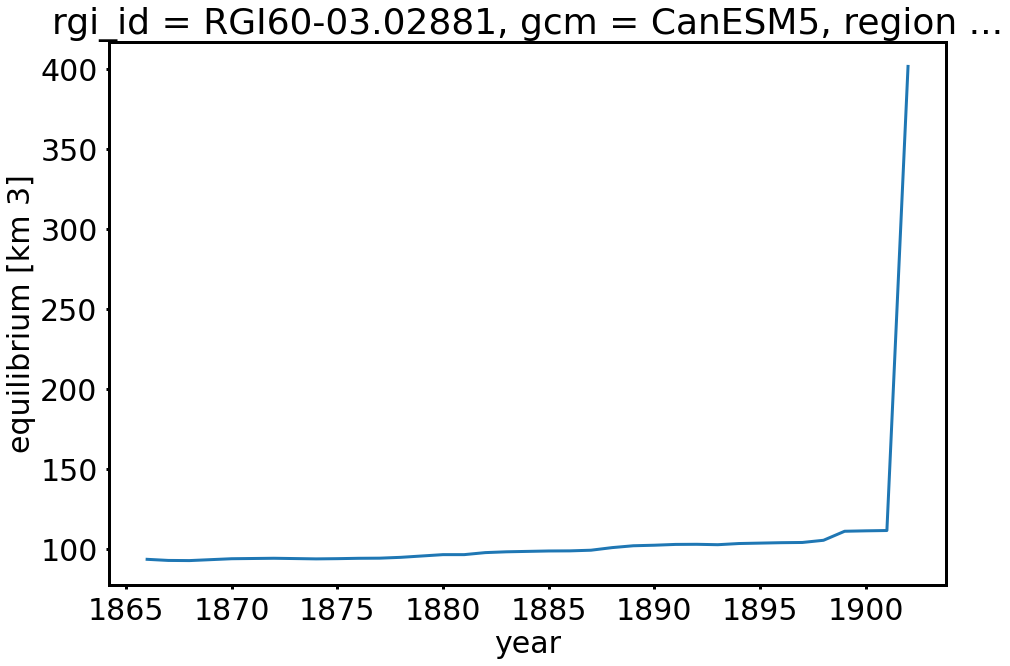

In [81]:
all_ds.sel(rgi_id=gdirs1[0].rgi_id, gcm='CanESM5').plot()

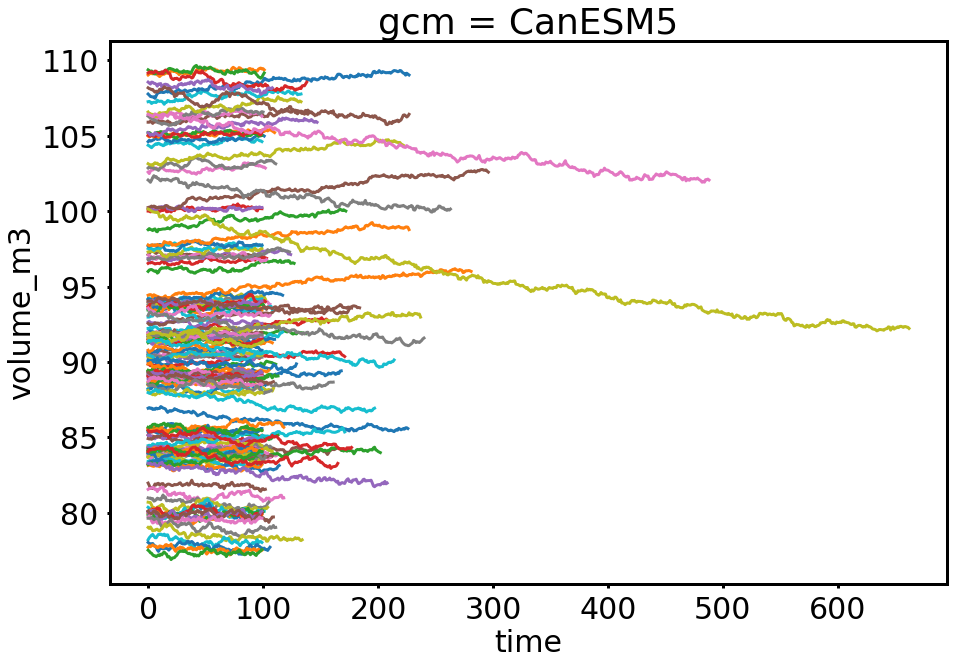

In [38]:
p = os.path.join(gdirs1[0].dir,'model_diagnostics_merged.nc')
d = (xr.open_dataset(p).volume_m3)/(1e9)
d.sel(gcm='CanESM5').drop_sel(year=1866).plot(hue='year',add_legend=False);

## Example plot for explaining how to calculate the equilibrium

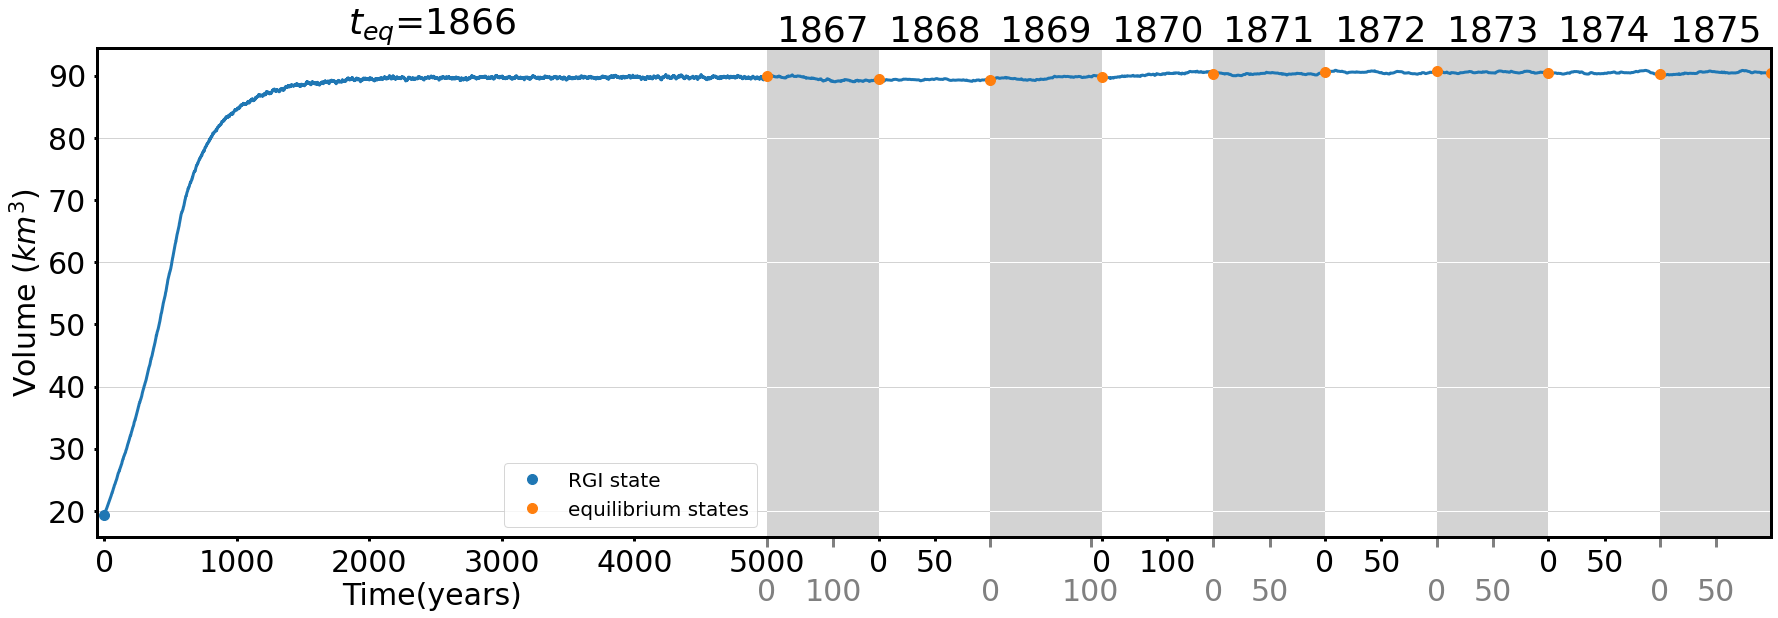

In [77]:
fig = plt.figure(figsize=(30,9))
grid = plt.GridSpec(1,15, hspace=0, wspace=0)
for i,t in enumerate(range(1866,1876)):
    if i==0:
        ax = fig.add_subplot(grid[:6])
        ax.plot(0,d.sel(year=t,time=0, gcm='CanESM5').values,'o',markersize=10, color='C0', zorder=3)
    else: 
        ax = fig.add_subplot(grid[i+5],sharey=ax)
        ax.plot(0,d.sel(year=t-1,time=last_year, gcm='CanESM5').values,'o',markersize=10, color='C1', zorder=3)
    d.sel(year=t).plot()
    ax.set_title(r'$t_{eq}$='+str(t))
    if i!=0:
        ax.axes.get_yaxis().set_visible(False)
        ax.set_xlabel('')
        ax.spines['left'].set_visible(False)
        ax.set_title(t)
    else:
        ax.set_xlabel('Time(years)')
        ax.set_ylabel('Volume $(km^3$)')
        ax.set_title(r'$t_{eq}$='+str(t))
    if t!=1875:
        ax.spines['right'].set_visible(False)
        
    if i % 2 != 0:
        ax.tick_params(axis='x', length=10, pad=30,labelcolor='grey',colors='grey')
        ax.set_facecolor('lightgrey')
        ax.hlines([20,40,60,80], xmin=-50,xmax=5000, color='white', lw=1) 
    else:
        ax.hlines([20,40,60,80], xmin=-50,xmax=5000, color='lightgrey', lw=1) 
    ax.set_xlim((15,90))
    last_year = d.sel(year=t).dropna(dim='time', how='any').time.values[-1]
    ax.plot(last_year,d.sel(year=t,time=last_year, gcm='CanESM5').values,'o',markersize=10, color='C1')
    if i!=0:
        ax.set_xlim(0,last_year)
      
    else:
        ax.set_xlim(-50,last_year)
        legend_elements = [Line2D([0], [0], marker= 'o', color='C0',lw=0, markersize=10,label='RGI state'),
                           Line2D([0], [0], marker= 'o', color='C1',lw=0, markersize=10,label='equilibrium states')]
        ax.legend(handles=legend_elements)
plt.savefig(os.path.join('out','run_CMIP6_geod','plots','example_equilibrium_runs.png'),dpi=300);

### Example stop at ocean line

In [4]:
gdirs = workflow.init_glacier_directories(rgidf.loc[['RGI60-03.00152']].reset_index(), reset=False)
gdir=gdirs[0]

2022-11-22 10:36:44: oggm.workflow: Execute entity tasks [GlacierDirectory] on 1 glaciers


In [5]:
gcm='CanESM5'
yr=1916
fp = gdir.get_filepath('model_geometry', filesuffix=gcm + '_' + str(yr - 1))
fmod16 = FileModel(fp)
no_nan_yr16 = fmod16.volume_m3_ts().dropna().index[-1]
fmod16.run_until(no_nan_yr16)

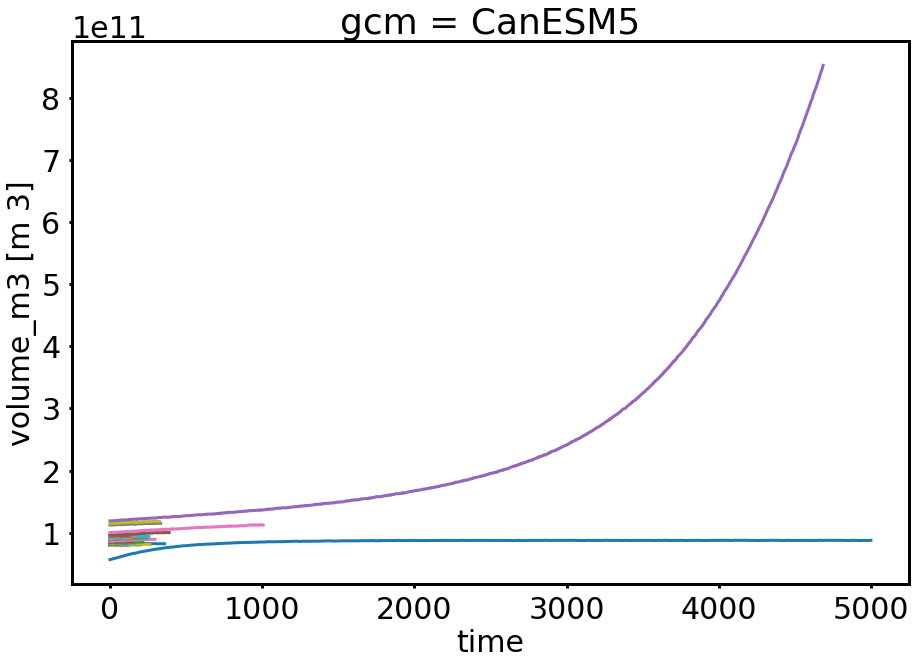

In [8]:

p = os.path.join(gdir.dir,'model_diagnostics_merged.nc')
ds = xr.open_dataset(p)
ax=plt.gca()
ds.sel(gcm='CanESM5').volume_m3.plot(hue='year', ax=ax,add_legend=False)
(fmod16.volume_m3_ts()).plot(ax=ax);
#plt.xlim(4000,5000)

In [9]:
ela=oggm.utils.compile_ela(gdir, filesuffix='CanESM5',ys=1850, ye=2034, climate_filename='gcm_data', climate_input_filesuffix='CanESM5')

2022-11-22 10:37:27: oggm.utils: Applying global task compile_ela on 1 glaciers
2022-11-22 10:37:27: oggm.workflow: Execute entity tasks [compute_ela] on 1 glaciers


In [196]:
ela.loc[1914:1920]

,RGI60-03.00152
1914,793.324869
1915,1005.579324
1916,957.806531
1917,760.519215
1918,754.455453
1919,933.838712
1920,779.091101


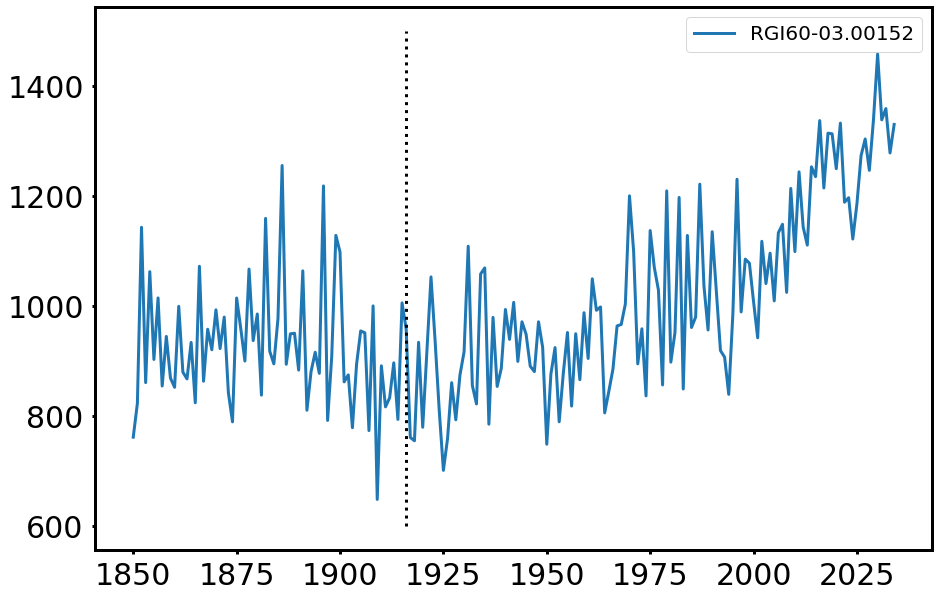

In [214]:
ela.plot()
plt.vlines(x=1916,ymin=600,ymax=1500, color='k', linestyle=':')
#plt.xlim(1900,1930)

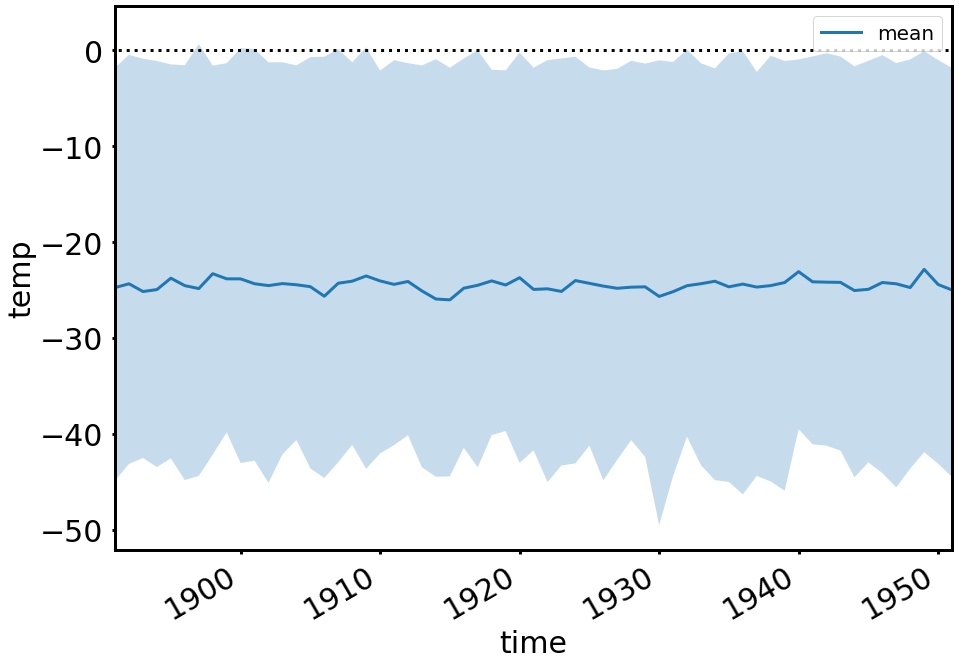

In [185]:
cl.temp.resample(time="Y").mean().plot(label='mean')
plt.fill_between(cl.temp.resample(time="Y").min().time,cl.temp.resample(time="Y").min(),cl.temp.resample(time="Y").max(),alpha=0.25)
plt.xlim([pd.to_datetime('1890-12-31 0:00:00'), pd.to_datetime('1950-12-31 00:00:00')])
plt.hlines(y=0,xmin=pd.to_datetime('1850-12-31 0:00:00'),xmax=pd.to_datetime('2034-12-31 0:00:00'),linestyle=':',color='k')
plt.legend()

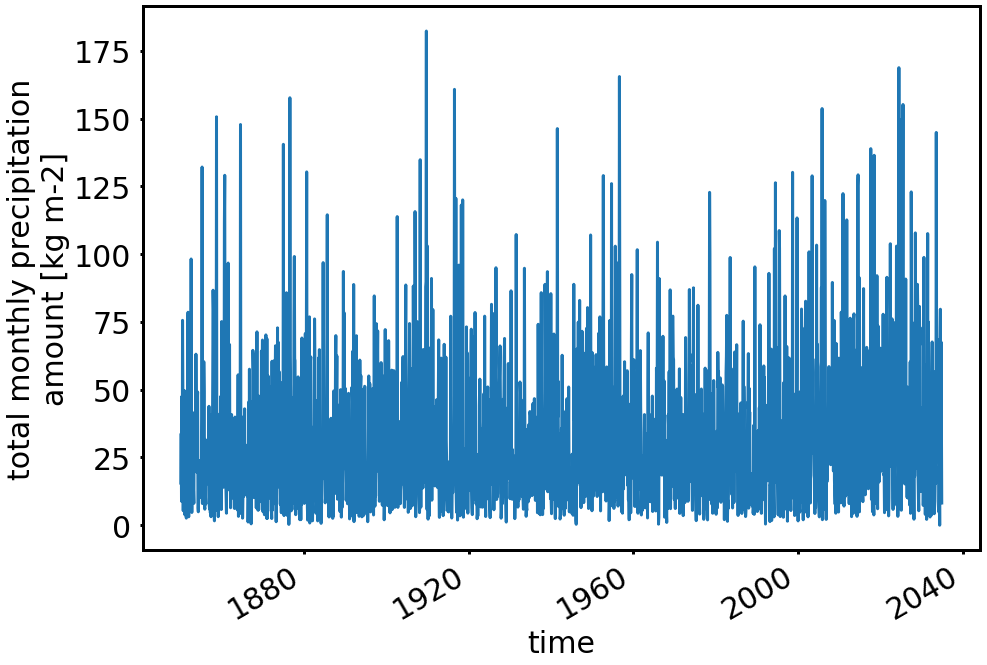

In [218]:
p = os.path.join(gdir.dir,'gcm_dataCanESM5.nc')
cl = xr.open_dataset(p)
cl.prcp.plot()


(0.0, 100.0)

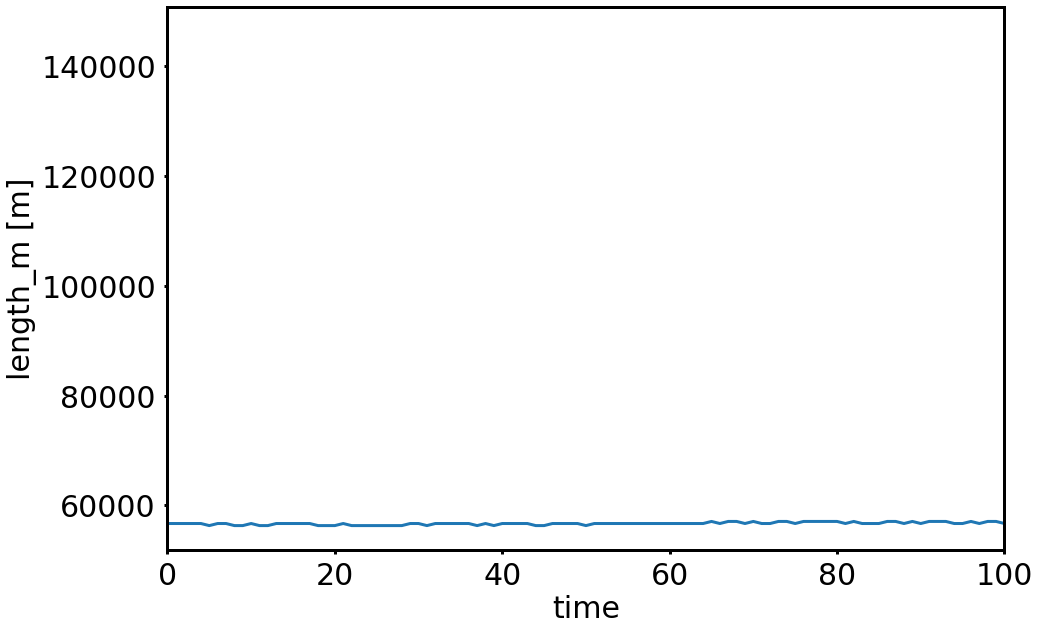

In [227]:
p = os.path.join(gdir.dir,'model_diagnosticsCanESM5_1915.nc')
ds1916 = xr.open_dataset(p)
ds1916.length_m.plot()
plt.xlim(0,100)

In [141]:
(fmod16.volume_m3_ts()*1e-9).plot(ax=ax)
ax

<AxesSubplot: title={'center': 'gcm = CanESM5'}, xlabel='time', ylabel='volume_m3 [m 3]'>

(0.0, 5000.0)

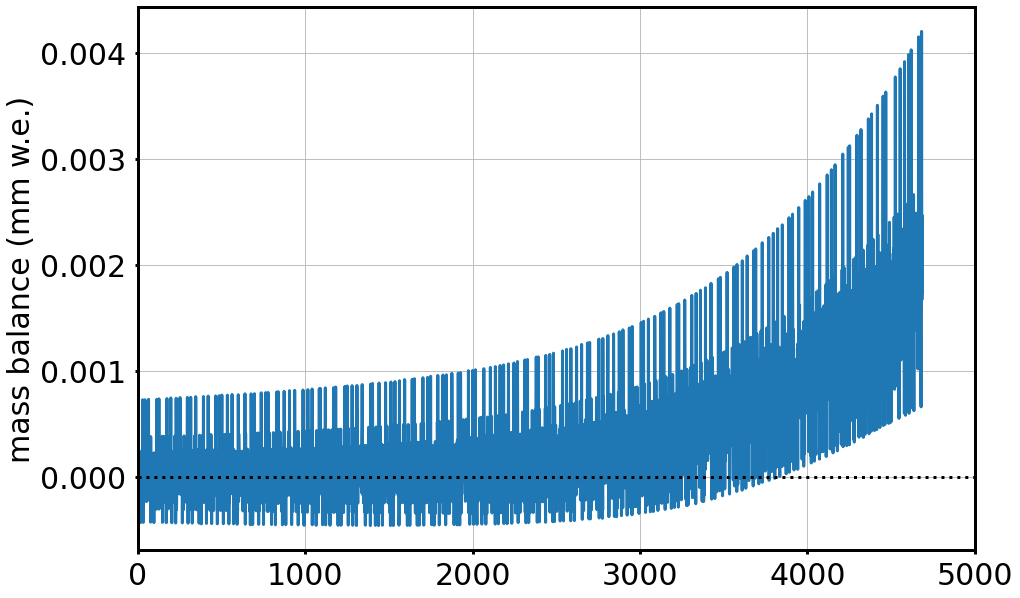

In [10]:
ax=plt.gca()
mb= (fmod16.volume_m3_ts()-fmod16.volume_m3_ts().shift())
mb = (mb*1e-9)* 0.9167
mb = mb* (1 / 361.8)
plt.hlines(y=0,xmin=0,xmax=5000, zorder=5, color='k', linestyle=':')
plt.grid()
plt.plot(mb)
plt.ylabel(r'mass balance (mm w.e.)')
plt.xlim(0,5000)

In [81]:
l = read_cmip6_data('cmip6_select',gdirs, ignore=['CanESM5','NorESM2-MM','EC-Earth3','IPSL-CM6A-LR-INCA','E3SM-1-1'], reset=False)
l

['CRU',
 'FGOALS-f3-L',
 'GISS-E2-2-H',
 'BCC-CSM2-MR',
 'MRI-ESM2-0',
 'CESM2',
 'MPI-ESM1-2-HR',
 'ACCESS-CM2',
 'MIROC6']

In [95]:
invert_years=False

climate_filename='climate_historical'
input_suffix=None

c = xr.open_dataset(gdir.get_filepath(climate_filename, filesuffix=input_suffix))
years =  range(c.time.to_series().iloc[0].year + 16, c.time.to_series().iloc[-1].year - 14)

if invert_years:
    years = years[::-1]
for i, yr in enumerate(years):
    if yr != years[0]:
        print(i,yr,years[i-1],)
    else:
        print(i,yr)

0 1917
1 1918 1917
2 1919 1918
3 1920 1919
4 1921 1920
5 1922 1921
6 1923 1922
7 1924 1923
8 1925 1924
9 1926 1925
10 1927 1926
11 1928 1927
12 1929 1928
13 1930 1929
14 1931 1930
15 1932 1931
16 1933 1932
17 1934 1933
18 1935 1934
19 1936 1935
20 1937 1936
21 1938 1937
22 1939 1938
23 1940 1939
24 1941 1940
25 1942 1941
26 1943 1942
27 1944 1943
28 1945 1944
29 1946 1945
30 1947 1946
31 1948 1947
32 1949 1948
33 1950 1949
34 1951 1950
35 1952 1951
36 1953 1952
37 1954 1953
38 1955 1954
39 1956 1955
40 1957 1956
41 1958 1957
42 1959 1958
43 1960 1959
44 1961 1960
45 1962 1961
46 1963 1962
47 1964 1963
48 1965 1964
49 1966 1965
50 1967 1966
51 1968 1967
52 1969 1968
53 1970 1969
54 1971 1970
55 1972 1971
56 1973 1972
57 1974 1973
58 1975 1974
59 1976 1975
60 1977 1976
61 1978 1977
62 1979 1978
63 1980 1979
64 1981 1980
65 1982 1981
66 1983 1982
67 1984 1983
68 1985 1984
69 1986 1985
70 1987 1986
71 1988 1987
72 1989 1988
73 1990 1989
74 1991 1990
75 1992 1991
76 1993 1992
77 1994 1993
7

In [76]:
def read_cmip6_data(path, gdirs,ignore=[], reset=False):
    l = ['CRU']
    for file in os.listdir(os.path.join(path,'tas')):
        if file.endswith('.nc'):
            name = file.split('_')[0]
            suffix = name.split('.')[2]
            if not suffix in ignore:
                tas_file = os.path.join(path, 'tas', file)
                pr_file = os.path.join(path, 'pr', name + '_pr.nc')
                if reset:
                    execute_entity_task(tasks.process_cmip_data, gdirs, filesuffix=suffix, fpath_temp=tas_file,
                                        fpath_precip=pr_file)
                l.append(suffix)
    return l

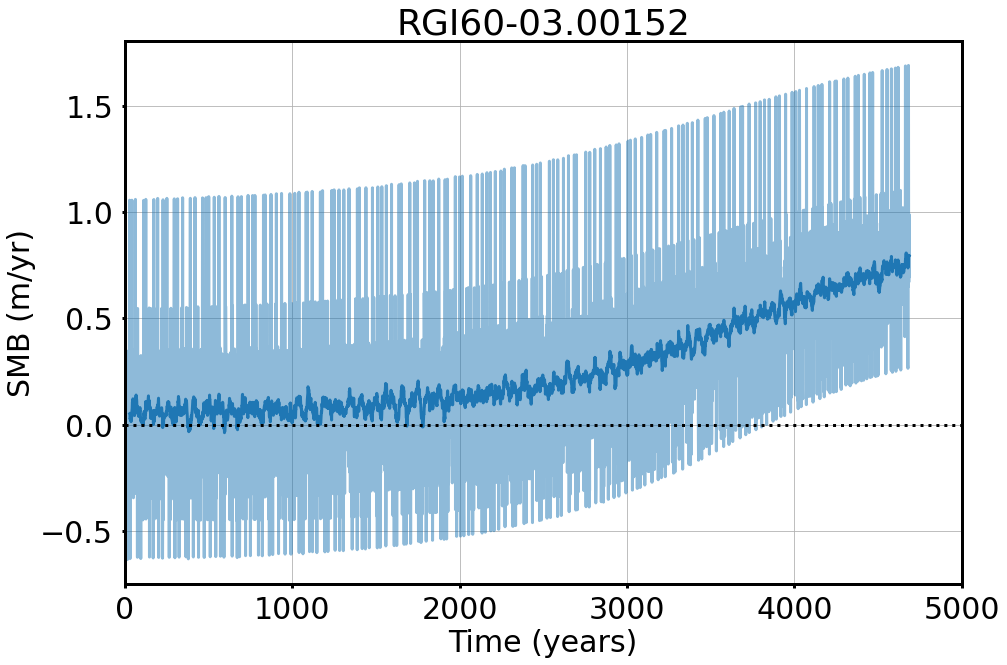

In [22]:
ax=plt.gca()
smb= (fmod16.volume_m3_ts()-fmod16.volume_m3_ts().shift())/fmod16.area_m2_ts()
plt.hlines(y=0,xmin=0,xmax=5000, zorder=5, color='k', linestyle=':')
plt.grid()
plt.plot(smb,alpha=0.5)
plt.plot(smb.rolling(window=30).mean(), color='C0')
plt.ylabel(r'SMB (m/yr)')
plt.xlabel('Time (years)')
plt.title(gdir.rgi_id)
plt.xlim(0,5000)
plt.savefig(os.path.join('out','run_CMIP6_geod','plots','glacier','calving_problem','SMB_'+gdir.rgi_id+'.png'),dpi=300);

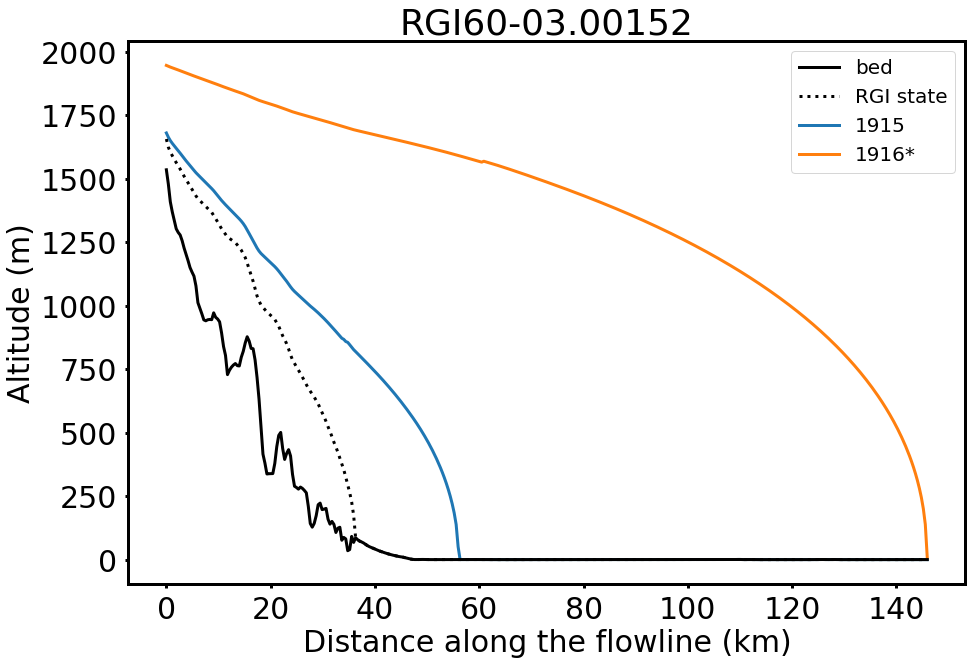

In [57]:
fls=gdir.read_pickle('model_flowlines')
x = (np.arange(fls[-1].nx) * fls[-1].dx * fls[-1].map_dx)/1000
plt.plot(x,fls[-1].bed_h,'k', label='bed', zorder=5)
plt.plot(x,fls[-1].surface_h,':k', label='RGI state', zorder=5)

fmod.run_until(no_nan_yr)
plt.plot(x,fmod.fls[-1].surface_h, label='1915')
fmod16.run_until(fmod16.volume_m3_ts().index[-1])
plt.plot(x,fmod16.fls[-1].surface_h, label='1916*')

plt.xlabel('Distance along the flowline (km)')
plt.ylabel('Altitude (m)')
plt.title(gdir.rgi_id)
plt.legend()
plt.savefig(os.path.join('out','run_CMIP6_geod','plots','glacier','calving_problem','geometry_'+gdir.rgi_id+'.png'),dpi=300);

In [33]:
fmod16.volume_m3_ts().index[-1]

4686.0

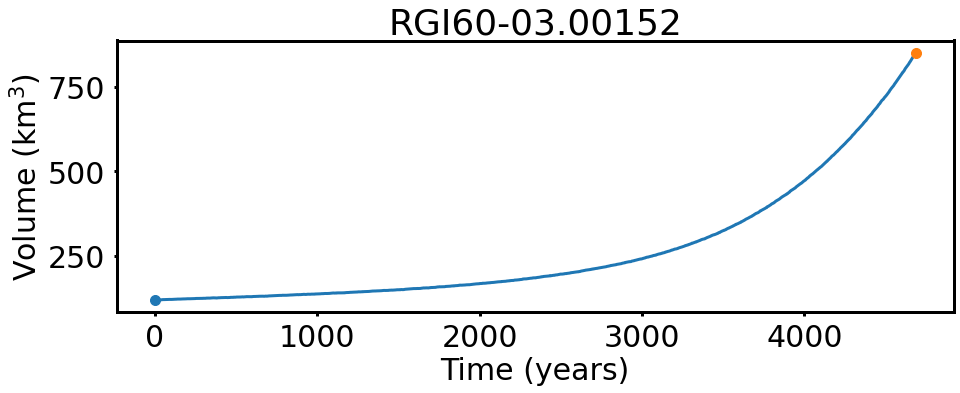

In [59]:
plt.figure(figsize=(15,5))
(fmod16.volume_m3_ts()*1e-9).plot()

plt.plot(fmod16.volume_m3_ts().index[-1],fmod16.volume_m3_ts().values[-1]*1e-9,'o',color='C1', markersize=10)
plt.plot(fmod16.volume_m3_ts().index[0],fmod16.volume_m3_ts().values[0]*1e-9,'o',color='C0', markersize=10)
plt.ylabel(r'Volume (km$^3$)')
plt.xlabel('Time (years)')
plt.title(gdir.rgi_id)
plt.savefig(os.path.join('out','run_CMIP6_geod','plots','glacier','calving_problem','volume_'+gdir.rgi_id+'.png'),dpi=300);

In [111]:
climate_filename='gcm_data'
input_suffix='CanESM5'
yr=1915
n_years=4686
f = partial(equilibrium_stop_criterion, n_years_specmb=100, spec_mb_threshold=10)
random.seed(yr)
seed = 0

mod = tasks.run_random_climate(gdir, climate_filename=climate_filename, climate_input_filesuffix=input_suffix, y0=yr,
                               nyears=n_years, unique_samples=True, output_filesuffix=gcm + '_' + str(yr),
                               stop_criterion=f, seed=seed, init_model_fls=fmod.fls)

## Example Smoothing the surface at before running the glacier 

In [22]:
rgidf.loc[['RGI60-03.04537']].reset_index()

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,check_geom,geometry
0,RGI60-03.04537,G287894E82067N,19999999,20039999,-72.1059,82.0666,3,1,161.792,574,...,1252,0,0,0,0,0,9,Abbe,None,"POLYGON ((-71.56148 82.10046, -71.56318 82.100..."


In [5]:
gdirs = workflow.init_glacier_directories(rgidf.loc[['RGI60-03.01538']].reset_index(), reset=False)
gdir=gdirs[0]

2022-11-21 09:27:36: oggm.workflow: Execute entity tasks [GlacierDirectory] on 1 glaciers


In [29]:
gdir

<oggm.GlacierDirectory>
  RGI id: RGI60-03.01538
  Region: 03: Arctic Canada North
  Subregion: 03-05: S Ellesmere Island (NW Devon)   
  Glacier type: Glacier
  Terminus type: Land-terminating
  Status: Glacier or ice cap
  Area: 88.795 km2
  Lon, Lat: (-80.94, 76.806)
  Grid (nx, ny): (578, 576)
  Grid (dx, dy): (142.0, -142.0)

In [19]:
gcm='CanESM5'
yr=1915
fp = gdir.get_filepath('model_geometry', filesuffix=gcm + '_' + str(yr - 1))
fmod = FileModel(fp)
no_nan_yr = fmod.volume_m3_ts().dropna().index[-1]
fmod.run_until(no_nan_yr)


(-71.9, 800.0)

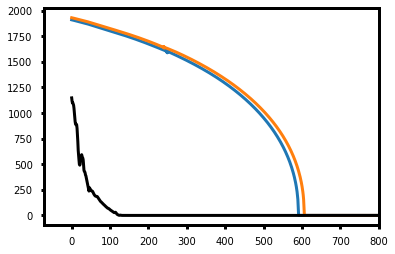

In [15]:
plt.plot(fmod68.fls[-1].surface_h)
plt.plot(fmod69.fls[-1].surface_h)
plt.plot(fmod69.fls[-1].bed_h,'k')
plt.xlim((None,800))
#plt.ylim((1500,1750))

In [73]:
climate_filename='gcm_data'
input_suffix='CanESM5'
yr=1868
n_years=58
f = partial(equilibrium_stop_criterion, n_years_specmb=100, spec_mb_threshold=10)
random.seed(yr)
seed = 0

mod = tasks.run_random_climate(gdir, climate_filename=climate_filename, climate_input_filesuffix=input_suffix, y0=yr,
                               nyears=n_years, unique_samples=True, output_filesuffix=gcm + '_' + str(yr),
                               stop_criterion=f, seed=seed, init_model_fls=fmod.fls)